# Project 1

## Question 1: Understanding the Dataset
Overview: How many rows (samples) and columns (features) are present in the dataset?

In [5]:
import pandas as pd
import numpy as np

# load the dataset!
df = pd.read_csv('Project1-ClassificationDataset.csv')
df.head()

# panda's shape returns a tuple (rows, cols)
rows = df.shape[0]
cols = df.shape[1]

print(f"\nNumber of samples: {rows}")
print(f"\nNumber of features: {cols}")



Number of samples: 3476

Number of features: 8


Histograms: Plot 3 histograms: 
<br>
(a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;
<br>
(b) The column leaf label – class on the x-axis; 
<br>
(c) The column root label – class on the x-axis

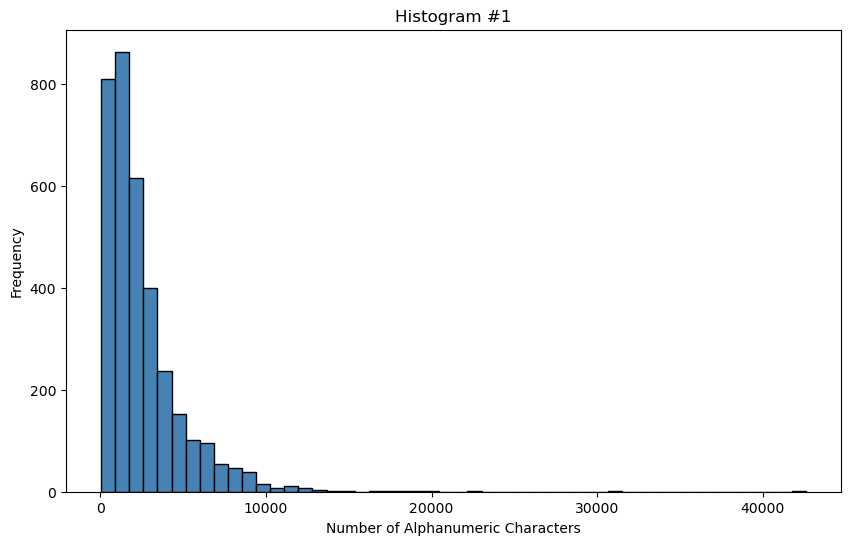

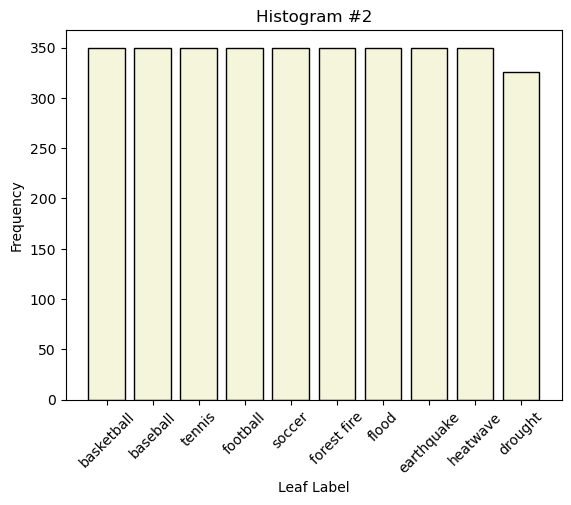

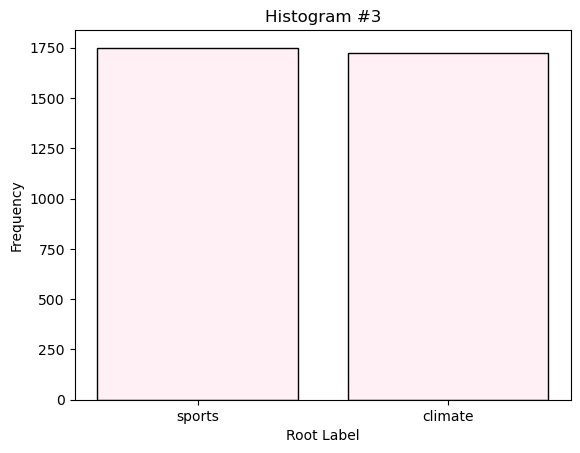

In [15]:
import matplotlib.pyplot as plt
import re

# (a)
df['alpha_num_char_count'] = df['full_text'].apply(lambda x: len(re.findall(r'\w', str(x)))) # count alphanumeric chars per row (A-Z, a-z) or (0-9) in full_text col

plt.figure(figsize=(10, 6))
plt.hist(df['alpha_num_char_count'], bins=50, color='steelblue', edgecolor='black')
plt.title('Histogram #1')
plt.xlabel('Number of Alphanumeric Characters')
plt.ylabel('Frequency')
plt.show()

# (b)
leaf_label_counts = df['leaf_label'].value_counts() # count leaf labels

plt.bar(leaf_label_counts.index, leaf_label_counts.values, color='beige', edgecolor='black')
plt.title('Histogram #2')
plt.xlabel('Leaf Label')
plt.ylabel('Frequency')
plt.xticks(rotation = 45)
plt.show()

# (c)
root_label_counts = df['root_label'].value_counts()

plt.bar(root_label_counts.index, root_label_counts.values, color='lavenderblush', edgecolor='black')
plt.title('Histogram #3')
plt.xlabel('Root Label')
plt.ylabel('Frequency')
plt.show()



Interpret Plots: Provide qualitative interpretations of the histograms.
<br>
<br>
a. The histogram is skewed to the left, with almost all rows containing 0-10k alphanumeric characters. This means that most news articles are pretty short. 
<br>
<br>
b. The histogram is evenly distributed, with almost all leaf labels having freq of around 350 except for drought which has around 325. This means that the dataset has the same amount of news articles in each of their categories.
<br>
<br>
c. The histogram is evenly distributed, with both sports and climate labels having a freq of around 1750. This means that news articles are also even in their broader categories, which is ideal because we don't have to worry about over and undersampling / imbalances!

## Question 2: Report the number of training and testing samples.

In [16]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

np.random.seed(42)
random.seed(42)

df = pd.read_csv('Project1-ClassificationDataset.csv')
train, test = train_test_split(df[['full_text', 'root_label']], test_size=0.2)

print(f"Number of training samples: {len(train)}")
print(f"Number of testing samples: {len(test)}")

Number of training samples: 2780
Number of testing samples: 696


## Question 3: Use the following specs to extract features from the textual data

In [19]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

df['cleaned_text'] = df['full_text'].apply(clean)


(a) What are the pros and cons of lemmatization versus stemming? How do these processes affect
the dictionary size?
<br>
<br>
(b) min df means minimum document frequency. How does varying min df change the TF-IDF
matrix?
<br>
<br>
(c) Should I remove stopwords before or after lemmatizing? Should I remove punctuations before
or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall
that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position
of every word based on the sentence structure.
<br>
<br>
(d) Report the shape of the TF-IDF-processed train and test matrices. The number of rows should
match the results of Question 2. The number of columns should roughly be in the order of
k ×103. This dimension will vary depending on your exact method of cleaning and lemmatizing
and that is okay.

## Question 4: Reduce the dimensionality of the data using the methods above
(a) Plot the explained variance ratio across multiple different k = [1, 5, 10, 25, 50, 100, 500, 1000]
for LSI and for the next few sections choose k = 25. What does the explained variance ratio
plot look like? What does the plot’s concavity suggest?

(b) With k = 25 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 25. Which one is larger?

## Question 5: Compare and contrast hard-margin and soft-margin linear SVMs: